# instructions:

This Jupyter Notebook can be used to search the Scielo Brazil network for desired keywords or phrases pertaining to research topics. For example, you can search for 'niobium', 'aerospace', or 'soybean biodiesel'. 

Note that if you search for a phrase with multiple words only clusters which contain all of that phrase's constituent words will show up in the results. Please do not include any punctuation in the search term. 

You can change the following parameters in text boxes/sliders:
- the search term
- the threshold for the minimum number of times a keyword must appear in a cluster to include it in search results
- the ID of the specific cluster you'd like to read through for detailed bibliographic information. Look at this after running previous cells - it's at the bottom of the page.

Don't change any of the other code or it won't work!

To use, first go to the "Cell" menu at the top left and click "Run All." This will set up the code along with a default example search. Then, enter your desired parameters and rerun the code by going to "Run All" again (or running individual cells if you know how). 

## setup code

In [1]:
import copy
from collections import Counter
import pandas as pd
import numpy as np
import networkx as nx
import nltk
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from adjustText import adjust_text
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

### enter your desired search term

In [2]:
try:
    q
except NameError:
    q = widgets.Text(value="biofuel")
else:
    q = widgets.Text(value=q.value)
display(q)

Text(value=u'biofuel')

### this slider sets the threshold for the minimum number of papers in a cluster that should contain each queried keyword. Set to 1 for the broadest possible search and increase if you want more specific resuls. 

In [3]:
try:
    c
except NameError:
    c = widgets.IntSlider(min=1, max=5, value=2)
else:
    c = widgets.IntSlider(min=1, max=5, value=c.value)
display(c)

IntSlider(value=2, max=5, min=1)

## after entering the above parameters you can either Run All or run the below cells individually. 

In [4]:
#don't change anything here
nltk.download('punkt')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

ps = PorterStemmer()
G1 = nx.read_gpickle('network_part1.pkl')
G2 = nx.read_gpickle('network_part2.pkl')
G3 = nx.read_gpickle('network_part3.pkl')
G4 = nx.read_gpickle('network_part4.pkl')
G = nx.compose(G1, G2)
G = nx.compose(G, G3)
G = nx.compose(G, G4)

groups = {}
grouplist = []
IDlist = []
x = []
y = []

for node in G.nodes():
    if type(node) == int:
        groups.setdefault(G.node[node]['group'],[]).extend(list(set(G.node[node]['TA_words'])))
        grouplist.append(G.node[node]['group'])
        IDlist.append(G.node[node]['index'])
        x.append(G.node[node]['viz']['position']['x'])
        y.append(G.node[node]['viz']['position']['y'])
        
nodeframe = pd.DataFrame({'ID': IDlist, 'Group': grouplist, 'x': x, 'y': y})

query = [ps.stem(item) for item in nltk.word_tokenize(q.value.lower())]
mycount = c.value
cluster_dict = {}
cluster_list = []
count_list = []
for i in groups:
    allthere = 1
    count = 9999
    for j in query:
        temp = groups[i].count(j)
        allthere = allthere * temp
        if temp < count:
            count = copy.deepcopy(temp)
    
    if count >= mycount and allthere > 0:
        cluster_dict[i] = {}
        cluster_dict[i]['nodes'] = []
        cluster_dict[i]['count'] = count
        count_list.append(cluster_dict[i]['count'])
        cluster_list.append(i)
        
for node in G.nodes():
    if G.node[node]['group'] in cluster_list:
        temp = copy.deepcopy(G.node[node])
        temp.pop('TA', None)
        temp.pop('TA_words', None)
        temp.pop('viz', None)
        cluster_dict[G.node[node]['group']]['nodes'].append(temp)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eprot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### the next cell shows search results for specific clusters, in a graph and a table

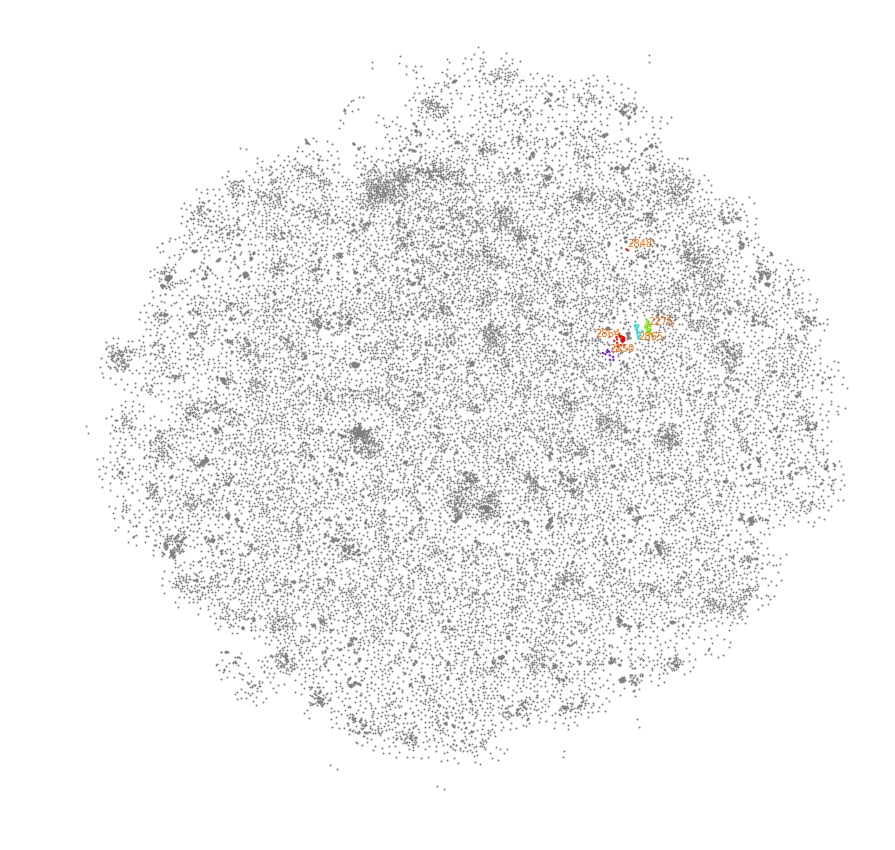

,hits,# papers,keywords
ID,,,
2275,2,2,sourc biomass biofuel xylanas hydrolysi isol step residu ferment enzym
2848,3,31,biodiesel oil ethanol fuel reaction liquid acid non diesel contain
2850,3,9,diesel fuel engin blend cycl ethanol emiss oper combust biodiesel
2864,3,24,yeast ferment cell saccharomyc cerevisia strain acid industri reduct food
2865,2,14,chemic acid composit cultiv yeast third compound ferment consum sourc


In [5]:
cluster_results = pd.DataFrame({'ID': cluster_list, 'hits': count_list})
cluster_results = cluster_results.set_index('ID')
cluster_results['# papers'] = 0
cluster_results['keywords'] = ''

for i in range(1,max(groups)+1):
    if i in cluster_results.index.values:
        cluster_results.loc[i, '# papers'] = len(cluster_dict[i]['nodes'])
        cluster_results.loc[i, 'keywords'] = ' '.join(t[0] for t in Counter(groups[i]).most_common(10))

nodehits = copy.deepcopy(nodeframe)
nodehits['bool'] = nodehits['Group'].isin(list(cluster_results.index))
nodehits = nodehits[nodehits['bool'] == True]
nodehits['group_color'] = pd.factorize(nodehits['Group'])[0]
cluster_results['x'] = nodehits.groupby('Group')['x'].mean()
cluster_results['y'] = nodehits.groupby('Group')['y'].mean()

fig, ax = plt.subplots(figsize=(15,15))
ax.axis("off")
ax.scatter(np.array(nodeframe[['x' ,'y']])[:,0], np.array(nodeframe[['x' ,'y']])[:,1], c="gray", s=1)
ax.scatter(np.array(nodehits[['x', 'y']])[:,0], np.array(nodehits[['x', 'y']])[:,1], c=list(nodehits['group_color']), cmap = plt.get_cmap("hsv"), s=1)
texts = [plt.text(list(cluster_results['x'])[i], list(cluster_results['y'])[i], list(set(list(nodehits['Group'])))[i], color='#ff6a00') for i in range(len(list(cluster_results['x'])))]
adjust_text(texts)
    
cluster_results = cluster_results.drop(['x', 'y'], axis=1)

authors = []
institutions = []

for i_id, i_item in cluster_dict.items():
    for j in i_item['nodes']:
        authors.extend(j['authors'])
        institutions.extend(j['affiliations'])

plt.show()  
cluster_results

### this lists the most common authors from the search
syntax is ('Author Name', # hits)

In [6]:
#don't change anything here
Counter(authors).most_common(20)

[(u'Miguel Angelo Mutton', 2),
 (u'Erika Cristina Francisco', 2),
 (u'Matthieu Tubino', 2),
 (u'Mariana Manzoni Maroneze', 2),
 (u'E. A. C. Batista', 2),
 (u'Marcia Justino Rossini Mutton', 2),
 (u'Andrea G. Capodaglio', 2),
 (u'Leila Queiroz Zepka', 2),
 (u'Eduardo Jacob-Lopes', 2),
 (u'Willian L. G. da Silva', 2),
 (u'Lirio Schaeffer', 2),
 (u'Paolo Viotti', 2),
 (u'Estefani P. Simao', 1),
 (u'Melissa Paola Mezzari', 1),
 (u'C. Arzola-Alvarez', 1),
 (u'Gustavo Henrique Gravatim Costa', 1),
 (u'Bogdan Minea', 1),
 (u'PAOLA DE CASTRO HENRIQUE', 1),
 (u'Alexandre Godoy', 1),
 (u'Daniella L. Vale', 1)]

### this lists the most common institutions
syntax is ('Institution', # hits)

In [7]:
#don't change anything here
Counter(institutions).most_common(10)

[(u'Universidade Federal da Bahia Salvador - BA - Brasil', 3),
 (u'Departamento de Tecnologia, Universidade Estadual de Maringa (UEM), Av. Angelo Moreira da Fonseca 180, Umuarama, PR, 87506-370, Brazil.',
  1),
 (u'Instituto Tecnologico de Aeronautica, Praca Marechal Eduardo Gomes, 50, Vila das Acacias, 12228-900 Sao Jose dos Campos-SP, Brazil',
  1),
 (u'Doutoranda em Ciencia dos Alimentos, Universidade Federal de Lavras. Bolsista CNPq . E-mail: vbanacarolina@yahoo.com.br',
  1),
 (u'Professor - UTFPR, Medianeira', 1),
 (u'Federal University of Santa Maria - Dept. of Food Science and Technology, Av. Roraima, 1000 - 97105-900 - Santa Maria, RS - Brazil.',
  1),
 (u'Laboratorio de Transformacao Mecanica, Universidade Federal do Rio Grande do Sul - UFRGS, Av. Bento Goncalves, 9500, CEP 91501-970, Porto Alegre, RS, Brazil',
  1),
 (u'CENPES, PETROBRAS, Av. Horacio Macedo, 950, Cidade Universitaria, 21941-915 Rio de Janeiro-RJ, Brazil',
  1),
 (u'School of Chemical and Minerals Engineering

### enter the cluster ID you want to examine, then either Run All or run just the cell below

In [12]:
try:
    cl
except NameError:
    cl = widgets.IntText(value=2275)
else:
    cl = widgets.IntText(value=cl.value)
display(cl)

IntText(value=2275)

In [13]:
cluster_dict[cl.value]['nodes']

[{u'abstract': u'Producing biofuels such as ethanol from non-food plant material has the potential to meet transportation fuel requirements in many African countries without impacting directly on food security. The current shortcomings in biomass processing are inefficient fermentation of plant sugars, such as xylose, especially at high temperatures, lack of fermenting microbes that are able to resist inhibitors associated with pre-treated plant material and lack of effective lignocellulolytic enzymes for complete hydrolysis of plant polysaccharides. Due to the presence of residual partially degraded lignocellulose in the gut, the dung of herbivores can be considered as a natural source of pre-treated lignocellulose. A total of 101 fungi were isolated (36 yeast and 65 mould isolates). Six yeast isolates produced ethanol during growth on xylose while three were able to grow at 42 degC. This is a desirable growth temperature as it is closer to that which is used during the cellulose hydr